# PatternMind loading dataset and performing EDA

### Imports

In [2]:
import os
import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive


### Mounting drive and locating dataset

We mount Google Drive to Colab so the notebook can access the ZIP file containing the PatternMind dataset.
We define two important variables:
ZIP_PATH → location of the dataset ZIP file inside Drive
EXTRACT_DIR → folder where the ZIP will be extracted.

This ensures that the dataset can be accessed.

In [3]:
drive.mount('/content/drive')
# Path to your ZIP file or extracted dataset
ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
EXTRACT_DIR = "/content/patternmind_dataset"


Mounted at /content/drive


In [4]:
#unzip
!unzip -q "{ZIP_PATH}" -d "{EXTRACT_DIR}"

We are listing the contents of the extracted directory to confirm proper extraction.

The dataset root folder can be seen:
System folders like __MACOSX (typical from macOS ZIP archives)

In [5]:
#folder check
!ls "{EXTRACT_DIR}"

__MACOSX  patternmind_dataset


### Collect all images

This block recursively scans the dataset directory and collects paths for all.jpg, .jpeg, and .png files.
Outcome:
A list of 25,557 images is detected.
Sample paths are printed for inspection.
This step creates the base list used for EDA and future dataloader creation.

In [6]:
DATA_DIR = EXTRACT_DIR  # dataset root
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []

for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_DIR, '**', ext), recursive=True))

print("Total images found:", len(image_paths))
image_paths[:5]


Total images found: 25557


['/content/patternmind_dataset/patternmind_dataset/hamburger/hamburger_34.jpg',
 '/content/patternmind_dataset/patternmind_dataset/hamburger/hamburger_61.jpg',
 '/content/patternmind_dataset/patternmind_dataset/hamburger/hamburger_67.jpg',
 '/content/patternmind_dataset/patternmind_dataset/hamburger/hamburger_49.jpg',
 '/content/patternmind_dataset/patternmind_dataset/hamburger/hamburger_41.jpg']

### Extract foler names

Each image is stored inside a folder named after the class (e.g., "hamburger").

Extracts the parent folder name for every image
Builds a pandas DataFrame with two columns:
`path` → `full path of the image`
`label` → `class name`
This structure simplifies counting classes, balancing data, and linking images to labels.

In [7]:
# folder name = class label
def get_class_from_path(path):
    return os.path.basename(os.path.dirname(path))

labels = [get_class_from_path(p) for p in image_paths]

df = pd.DataFrame({
    "path": image_paths,
    "label": labels
})

df.head()

,path,label
0,/content/patternmind_dataset/patternmind_datas...,hamburger
1,/content/patternmind_dataset/patternmind_datas...,hamburger
2,/content/patternmind_dataset/patternmind_datas...,hamburger
3,/content/patternmind_dataset/patternmind_datas...,hamburger
4,/content/patternmind_dataset/patternmind_datas...,hamburger


### Count images per class

Here the notebook computes the number of images per class:
value_counts() gives a frequency table

The histogram visualizes distribution of class sizes
It identifies whether the dataset is `balanced` or `imbalanced`
Evaluate whether augmentation or resampling might be needed in modeling.

In [8]:
class_counts = df["label"].value_counts().sort_values(ascending=False)

print("Number of classes:", len(class_counts))
class_counts.head(10)


Number of classes: 233


,count
label,
clutter,761
airplanes,720
motorbikes,719
faces-easy,396
t-shirt,330
hammock,257
billiards,251
horse,246
ladder,223


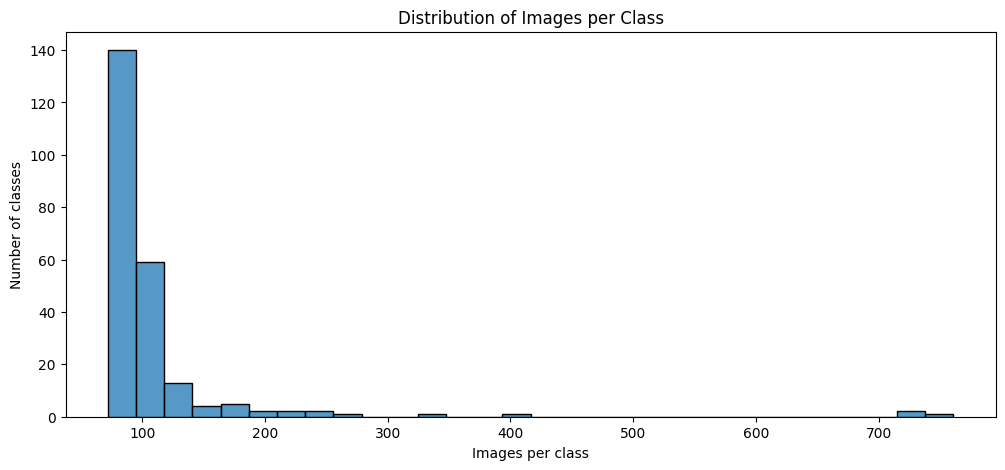

In [9]:
plt.figure(figsize=(12, 5))
sns.histplot(class_counts, bins=30)
plt.title("Distribution of Images per Class")
plt.xlabel("Images per class")
plt.ylabel("Number of classes")
plt.show()

### Check corrupted images

Iterates over all image paths and attempts to open and verify each image.
If a file fails verification, it is added to `bad_files`.


In [10]:
bad_files = []

for path in tqdm(image_paths, desc="Checking corrupted images"):
    try:
        img = Image.open(path)
        img.verify()   # verify file integrity
    except Exception:
        bad_files.append(path)

print("Corrupted files found:", len(bad_files))
bad_files[:5]


Checking corrupted images: 100%|██████████| 25557/25557 [00:15<00:00, 1636.51it/s]

Corrupted files found: 0


[]

### File extensions

Counts the frequency of file extensions (e.g., .jpg, .png).
Useful for understanding dataset consistency and detecting unexpected formats.

In [11]:
exts = df["path"].apply(lambda x: os.path.splitext(x)[1].lower()).value_counts()
exts

,count
path,
.jpg,25557


### Basic dimention statistic on a sample of 200

Randomly selects 200 images and measures their width and height.
Computing average values across the sampled images.

In [14]:
sample_paths = np.random.choice(image_paths, size=200, replace=False)

widths, heights = [], []

for p in sample_paths:
    try:
        img = Image.open(p)
        w, h = img.size
        widths.append(w)
        heights.append(h)
    except:
        pass

print("Avg width:", np.mean(widths))
print("Avg height:", np.mean(heights))


Avg width: 360.04
Avg height: 309.095
